In [1]:
import pandas as pd
import pickle
import glob
import os
from psimapacthelper import *
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in _binom_pdf")

# Generating the required metrics

In [2]:
### Read the data

# Specify the folder path containing pickle files
folder_path = 'Calibration/final_data'

# Define the pattern to match for pickle files
file_pattern = 'datalist_seed*.pkl'

# Find all matching files
file_paths = glob.glob(os.path.join(folder_path, file_pattern))

# Initialize an empty dictionary to store loaded data
loaded_data = {}

# Load each pickle file
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        # Extract the seed number from the file name
        seed_number = int(file_path.split('seed')[1].split('.')[0])
        # Load the pickle file and store in the dictionary
        loaded_data[f'model{seed_number}'] = pickle.load(f)

In [3]:
loaded_data.keys()

dict_keys(['model1', 'model14', 'model27', 'model12', 'model5', 'model2', 'model22', 'model8', 'model4', 'model20', 'model9', 'model28', 'model15', 'model16', 'model25', 'model29', 'model3', 'model17', 'model21', 'model24', 'model26', 'model19', 'model11', 'model6', 'model10', 'model7', 'model30', 'model13', 'model18', 'model23'])

In [4]:
sim_size = 2000
scaling_factor = 611454/sim_size

In [5]:
agegroup = [15, 50]
evaluation_timepoints = np.arange(1, 72.0, 1.0) # 

In [6]:
evaluation_timepoints_inc = np.arange(0, 71.0, 1.0) 

In [7]:
# Define mapping from gender and timepoint to years,
gender = {
    0: 'Men',
    1: 'Women',
    'Total':'Total'}

timepoint_to_year = {timepoint: year for timepoint, year in enumerate(range(1980, 2051))}

In [8]:
excel_file = f'Calibration/final_data/final_output_calib_version_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.xlsx'
excel_file

'Calibration/final_data/final_output_calib_version_2024-08-19_11:28:49.xlsx'

### Population Size age 15-49 

In [9]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = pop_size_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint-1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
pop_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
pop_combined_df['Year'] = pop_combined_df['timepoint'].map(timepoint_to_year)
pop_combined_df['Gender'] = pop_combined_df['Gender'].map(gender)

In [10]:
population_df = pop_combined_df.groupby(['Gender','Year']).agg(
            Population=('popsize_y', 'mean')  # Average pop for each gender
        ).reset_index()

population_df['Actual_Population'] = round(population_df['Population']*scaling_factor)

In [11]:
population_wide_df = population_df.pivot(index='Year', columns='Gender', values='Actual_Population').reset_index()
population_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)

In [12]:
fig = px.line(data_frame=population_wide_df, x='Year', y=['Women','Men'], width=1000, height=500)
fig.update_layout(legend_title=dict(text=""), yaxis_title="Population size")

# Data points to add
points = [
    {'Year': 1980, 'Women': 139681, 'Men': 125845}, #US Census Beaureau
    {'Year': 2000, 'Women': 259643, 'Men': 241315}, #US Census Beaureau
    {'Year': 2010, 'Women': 289701, 'Men': 257100}, #US Census Beaureau
    {'Year': 2017, 'Women': 311605, 'Men': 274896}, #US Census Beaureau
    #{'Year': 2030, 'Women': 360887, 'Men': 322230}, #Estimate by US Census Beaureau
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points',
        marker=dict(color='red', size=6)
    )
)

fig.show()

In [13]:
fig = px.line(data_frame=population_wide_df, x='Year', y='Total', width=1000, height=500)
fig.update_layout(legend_title=dict(text=""), yaxis_title="Population size")

### HIV prevalence age 15-49 population

In [14]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        result_df = prevalence_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint-1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_combined_df['Year'] = prev_combined_df['timepoint'].map(timepoint_to_year)
prev_combined_df['Gender'] = prev_combined_df['Gender'].map(gender)

In [15]:
prevalence_df = prev_combined_df.groupby(['Gender','Year']).agg(
            popsize=('popsize', 'sum'),  # Average pop for each gender
            sum_cases = ('sum_cases', 'sum')
        ).reset_index()

prevalence_df['pointprevalence'] = prevalence_df['sum_cases']/prevalence_df['popsize']
prevalence_df

Gender  Year  popsize  sum_cases  pointprevalence
0      Men  1980    13402          0         0.000000
1      Men  1981    13938          0         0.000000
2      Men  1982    14452          0         0.000000
3      Men  1983    15002          0         0.000000
4      Men  1984    15579          0         0.000000
..     ...   ...      ...        ...              ...
208  Women  2046    43602       4664         0.106968
209  Women  2047    44094       4368         0.099061
210  Women  2048    44711       4090         0.091476
211  Women  2049    45226       3785         0.083691
212  Women  2050    45824       3513         0.076663

[213 rows x 5 columns]

In [16]:
prevalence_wide_df = prevalence_df.pivot(index='Year', columns='Gender', values='pointprevalence').reset_index()
prevalence_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)

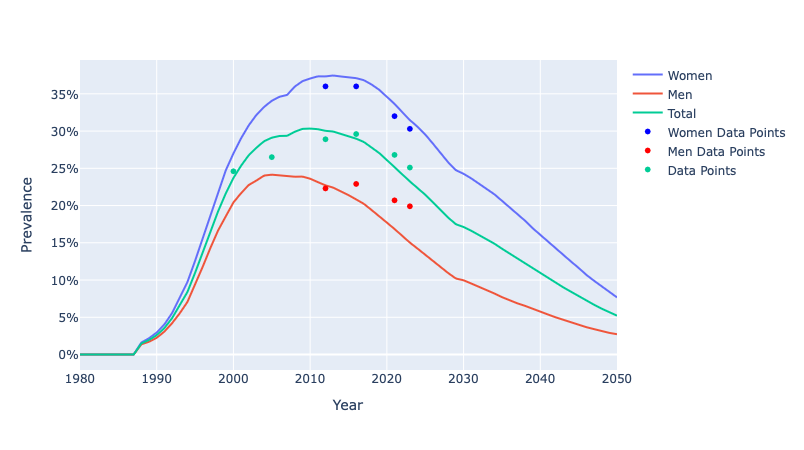

In [17]:
fig = px.line(data_frame=prevalence_wide_df, x='Year', y=['Women','Men', 'Total'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Prevalence", legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2000, 'Women': np.nan, 'Men': np.nan, 'Total': .246}, #UNAIDS
    {'Year': 2005, 'Women': np.nan, 'Men': np.nan, 'Total': .265}, #UNAIDS
    {'Year': 2012, 'Women': .36, 'Men': .223, 'Total': .289}, # my estimate UNAIDS
    {'Year': 2016, 'Women': .36, 'Men': .229, 'Total': .296}, # my estimate UNAIDS
    {'Year': 2021, 'Women': .32, 'Men': .207, 'Total': .268}, # my estimate UNAIDS
    {'Year': 2023, 'Women': .303, 'Men': .199, 'Total': .251}, #UNAIDS
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points',
        marker=dict(color='red', size=6)
    )
)

fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

### HIV incidence as new infections per 1000 uninfected population  (15-49)

In [ ]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df['Year'] = inc_combined_df['timepoint'].map(timepoint_to_year)
inc_combined_df['Gender'] = inc_combined_df['Gender'].map(gender)

In [ ]:
inc_combined_df

In [ ]:
incidence_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_exposure_time=('sum_exposure_time', 'sum'),  
            sum_incident_cases = ('sum_incident_cases', 'sum')
        ).reset_index()

incidence_df['incidence']  = incidence_df['sum_incident_cases']/incidence_df['sum_exposure_time']
incidence_df['incidence'] = round(incidence_df['incidence'] * 1000, 3)
incidence_df

In [ ]:
incidence_wide_df = incidence_df.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV incidence per 1000', index=False)

In [ ]:
fig = px.line(data_frame=incidence_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-49)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': np.nan, 'Men': np.nan,'Total': 39.1},
    {'Year': 2004, 'Women': np.nan, 'Men': np.nan, 'Total': 34.5},
    {'Year': 2008, 'Women': np.nan, 'Men': np.nan, 'Total': 30.4},
    {'Year': 2012, 'Women': 38.6, 'Men': 20.3, 'Total': 29.8}, #shims1 16.5:31.4
    {'Year': 2016, 'Women': 24.4, 'Men': 12.2, 'Total': 18.3}, #shims2 9.9:19.9
    {'Year': 2021, 'Women': 16.64, 'Men': 2.56,'Total': 9.6}, #shims3 2:14.5 Total 7.7
    {'Year': 2023, 'Women': 13.33, 'Men': 2.05, 'Total': 7.69}, #UNAIDS
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

### True ART Coverage age 15+ (Percentage of people living with HIV who are on antiretroviral treatment)

In [24]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        result_df = ART_coverage_calculator(datalist=datalist, agegroup=[15, 300],timepoint=timepoint)
        result_df['timepoint'] = timepoint -1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
ART_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
ART_combined_df['Year'] = ART_combined_df['timepoint'].map(timepoint_to_year)
ART_combined_df['Gender'] = ART_combined_df['Gender'].map(gender)

In [25]:
ART_df = ART_combined_df.groupby(['Gender','Year']).agg(
            sum_cases=('sum_cases', 'sum'),  # Average pop for each gender
            sum_onART = ('sum_onART', 'sum')
        ).reset_index()
ART_df['ART_coverage_True'] = ART_df['sum_onART']/ART_df['sum_cases']
ART_df

Gender  Year sum_cases sum_onART ART_coverage_True
0      Men  1988       256         0               0.0
1      Men  1989       343         0               0.0
2      Men  1990       469         0               0.0
3      Men  1991       664         0               0.0
4      Men  1992       938         0               0.0
..     ...   ...       ...       ...               ...
184  Women  2046      8744      8539          0.976555
185  Women  2047      8455      8263          0.977292
186  Women  2048      8204      8023          0.977938
187  Women  2049      7954      7778          0.977873
188  Women  2050      7668      7505          0.978743

[189 rows x 5 columns]

In [26]:
ART_wide_df = ART_df.pivot(index='Year', columns='Gender', values='ART_coverage_True').reset_index()
ART_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART True Coverage', index=False)

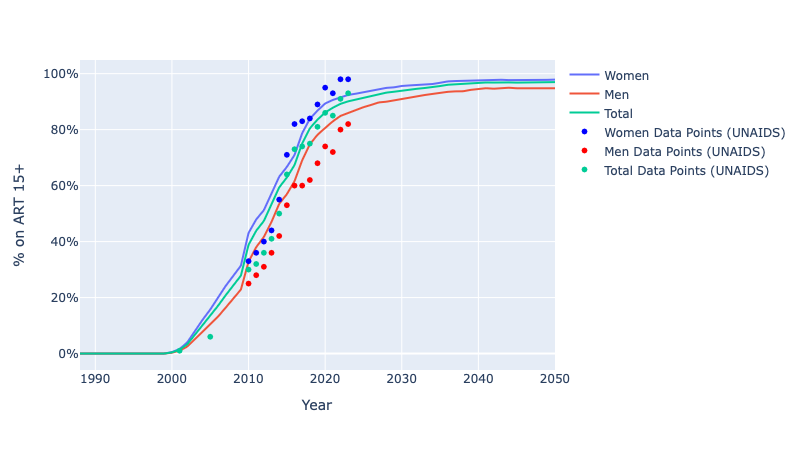

In [27]:
fig = px.line(data_frame=ART_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% on ART 15+",
    legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2001, 'Women':np.nan, 'Men': np.nan, 'Total':0.01},
    {'Year': 2005, 'Women':np.nan, 'Men': np.nan, 'Total':0.06},
    {'Year': 2010, 'Women': 0.33, 'Men': 0.25, 'Total': 0.30},
    {'Year': 2011, 'Women': 0.36, 'Men': 0.28, 'Total': 0.32},
    {'Year': 2012, 'Women': 0.40, 'Men': 0.31, 'Total': 0.36},
    {'Year': 2013, 'Women': 0.44, 'Men': 0.36, 'Total': 0.41},
    {'Year': 2014, 'Women': 0.55, 'Men': 0.42, 'Total': 0.50},
    {'Year': 2015, 'Women': 0.71, 'Men': 0.53, 'Total': 0.64}, 
    {'Year': 2016, 'Women': 0.82, 'Men': 0.60, 'Total': 0.73}, 
    {'Year': 2017, 'Women': 0.83, 'Men': 0.60, 'Total': 0.74}, 
    {'Year': 2018, 'Women': 0.84, 'Men': 0.62, 'Total': 0.75}, 
    {'Year': 2019, 'Women': 0.89, 'Men': 0.68, 'Total': 0.81}, 
    {'Year': 2020, 'Women': 0.95, 'Men': 0.74, 'Total': 0.86}, 
    {'Year': 2021, 'Women': 0.93, 'Men': 0.72, 'Total': 0.85}, 
    {'Year': 2022, 'Women': 0.98, 'Men': 0.80, 'Total': 0.91}, 
    {'Year': 2023, 'Women': 0.98, 'Men': 0.82, 'Total': 0.93}, 
    # Add more points as needed
]



# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (UNAIDS)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (UNAIDS)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)


fig.show()

### Of those diagnosed, % on ART age 15-49

In [28]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = ART_coverage_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
ART_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
ART_combined_df['Year'] = ART_combined_df['timepoint'].map(timepoint_to_year)
ART_combined_df['Gender'] = ART_combined_df['Gender'].map(gender)

In [29]:
ART_df = ART_combined_df.groupby(['Gender','Year']).agg(
            sum_diagnosed=('sum_diagnosed', 'sum'),  # Average pop for each gender
            sum_onART = ('sum_onART', 'sum')
        ).reset_index()

ART_df['sum_diagnosed'] = pd.to_numeric(ART_df['sum_diagnosed'], errors='coerce')
ART_df['sum_onART'] = pd.to_numeric(ART_df['sum_onART'], errors='coerce')

ART_df

Gender  Year  sum_diagnosed  sum_onART
0      Men  1988              0          0
1      Men  1989              0          0
2      Men  1990              0          0
3      Men  1991              0          0
4      Men  1992              7          0
..     ...   ...            ...        ...
184  Women  2046           4472       4463
185  Women  2047           4187       4179
186  Women  2048           3916       3912
187  Women  2049           3617       3613
188  Women  2050           3355       3353

[189 rows x 4 columns]

In [30]:
# Calculate ART_coverage with division by zero handling
ART_df['ART_coverage'] = np.where(
    ART_df['sum_diagnosed'] == 0,
    np.nan,  # or use 0 or another value if preferred
    ART_df['sum_onART'] / ART_df['sum_diagnosed']
)
ART_df

Gender  Year  sum_diagnosed  sum_onART  ART_coverage
0      Men  1988              0          0           NaN
1      Men  1989              0          0           NaN
2      Men  1990              0          0           NaN
3      Men  1991              0          0           NaN
4      Men  1992              7          0      0.000000
..     ...   ...            ...        ...           ...
184  Women  2046           4472       4463      0.997987
185  Women  2047           4187       4179      0.998089
186  Women  2048           3916       3912      0.998979
187  Women  2049           3617       3613      0.998894
188  Women  2050           3355       3353      0.999404

[189 rows x 5 columns]

In [31]:
ART_wide_df = ART_df.pivot(index='Year', columns='Gender', values='ART_coverage').reset_index()
ART_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage (second 95)', index=False)

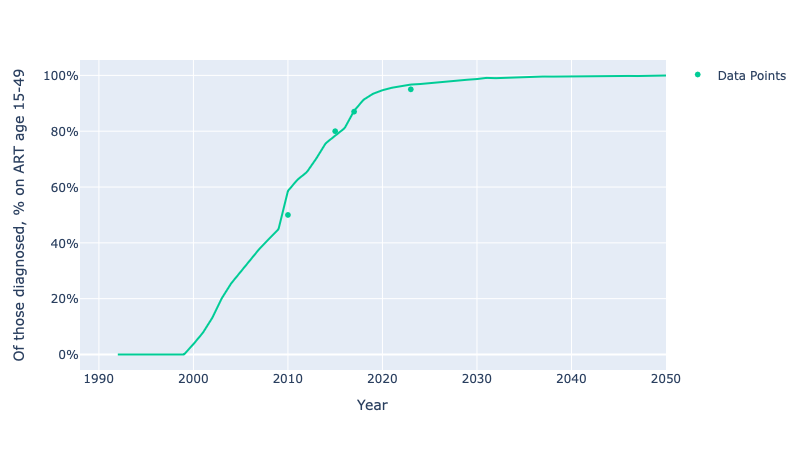

In [32]:
fig = px.line(data_frame=ART_wide_df, x='Year', y='Total',width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Of those diagnosed, % on ART age 15-49",
    legend_title=dict(text=""),yaxis_tickformat='.0%'
)
# Update the line color to green
fig.update_traces(line=dict(color='#00CC96'))

# Data points to add
points = [
    {'Year': 2010, 'Total': 0.5},
    {'Year': 2015, 'Total': 0.8},
    {'Year': 2017, 'Total': 0.87},
    {'Year': 2023, 'Total': 0.95},
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#00CC96', size=6)
    )
)


fig.show()

### New HIV infections age 15-49 pop

In [33]:
new_infections_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_incident_cases=('sum_incident_cases', 'mean')  # Average pop for each gender
        ).reset_index()

new_infections_df['sum_incident_cases_actual'] = round(new_infections_df['sum_incident_cases']*scaling_factor)

In [34]:
new_infections_wide_df = new_infections_df.pivot(index='Year', columns='Gender', values='sum_incident_cases_actual').reset_index()
new_infections_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)

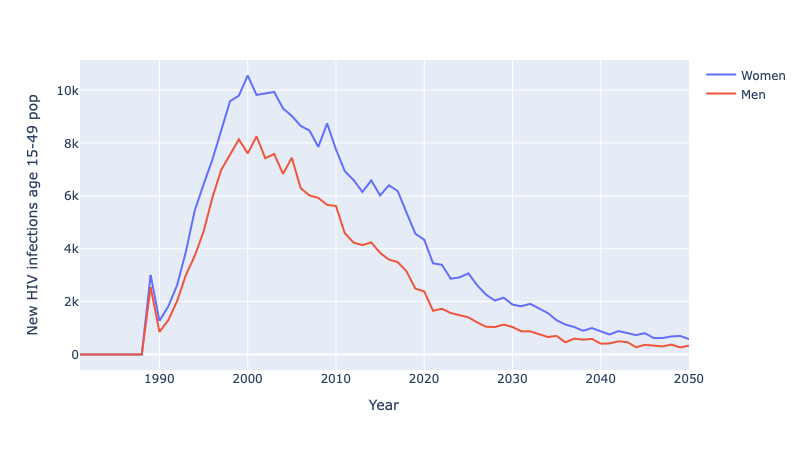

In [35]:
fig = px.line(data_frame=new_infections_wide_df, x='Year', y=['Women','Men'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="New HIV infections age 15-49 pop",
    legend_title=dict(text="")
)
fig.show()

### Number of people on treatment (all ages)

In [36]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        agegroup = [0, 300]
        result_df = ART_coverage_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
ART_numbers_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
ART_numbers_df['Year'] = ART_numbers_df['timepoint'].map(timepoint_to_year)
ART_numbers_df['Gender'] = ART_numbers_df['Gender'].map(gender)

In [37]:
ART_numbers_combined_df = ART_numbers_df.groupby(['Gender','Year']).agg(
            ART_numbers_all=('sum_onART', 'mean')  # Average pop for each gender
        ).reset_index()

ART_numbers_combined_df['ART_numbers_all_actual'] = ART_numbers_combined_df['ART_numbers_all']*scaling_factor

In [38]:
ART_numbers_combined_wide_df = ART_numbers_combined_df.pivot(index='Year', columns='Gender', values='ART_numbers_all_actual').reset_index()
ART_numbers_combined_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)

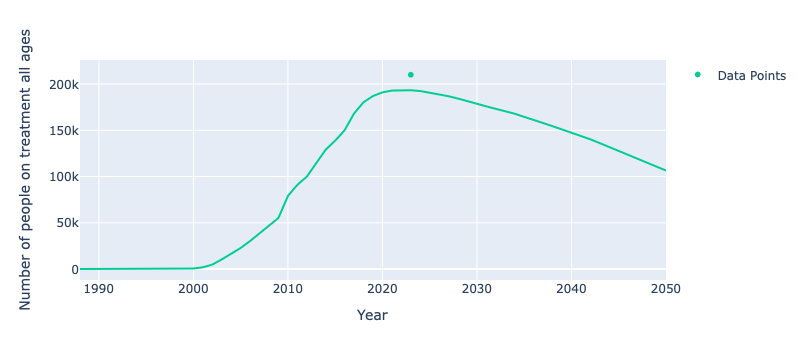

In [39]:
fig = px.line(data_frame=ART_numbers_combined_wide_df, x='Year', y='Total')

fig.update_layout(
    xaxis_title="Year", yaxis_title="Number of people on treatment all ages",
    legend_title=dict(text="")
)
# Update the line color to green
fig.update_traces(line=dict(color='#00CC96'))

# Data points to add
points = [
    {'Year': 2023, 'Total': 210000},
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#00CC96', size=6)
    )
)

fig.show()

### Of those on ART, % VL<1000 age 15-49

In [40]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = VL_suppression_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint, vl_cutoff=1000)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VL_combined_df = pd.concat(dfs, ignore_index=True)
VL_combined_df = VL_combined_df.dropna(subset=['Gender'])
# Replace timepoint with years, gender with actual gender string
VL_combined_df['Year'] = VL_combined_df['timepoint'].map(timepoint_to_year)
VL_combined_df['Gender'] = VL_combined_df['Gender'].map(gender)

In [41]:
VL_df = VL_combined_df.groupby(['Gender','Year']).agg(
            sum_onART=('sum_onART', 'sum'),  # sum acros all models each gender
            sum_vl_suppr = ('sum_vl_suppr','sum')
        ).reset_index()

VL_df['vl_suppr_frac'] = VL_df['sum_vl_suppr']/VL_df['sum_onART'] 

In [42]:
VL_wide_df = VL_df.pivot(index='Year', columns='Gender', values='vl_suppr_frac').reset_index()
VL_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)

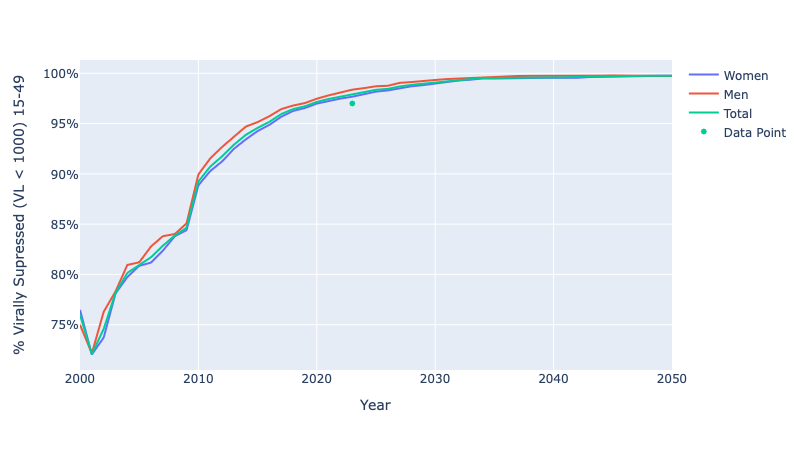

In [43]:
fig = px.line(data_frame=VL_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% Virally Supressed (VL < 1000) 15-49",
    legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2023, 'Women': np.nan, 'Men': np.nan, 'Total': 0.97},
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Point',
        marker=dict(color='#00CC96', size=6)
    )
)

fig.show()

### % of 15-49 men who have had VMMC

In [44]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = vmmc_calculator(datalist=datalist, agegroup=[15,50],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VMMC_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
VMMC_combined_df['Year'] = VMMC_combined_df['timepoint'].map(timepoint_to_year)

In [45]:
VMMC_df = VMMC_combined_df.groupby(['Gender','Year']).agg(
            popsize=('popsize', 'mean'),  # sum acros all models each gender
            sum_circumcised = ('sum_circumcised', 'mean'),
            popsize_all=('popsize', 'sum'),  # sum acros all models each gender
            sum_circumcised_all = ('sum_circumcised', 'sum'),
            vmmcprevalence = ('vmmcprevalence','mean')
        ).reset_index()

VMMC_df['vmmcprevalence_']  = round(VMMC_df['sum_circumcised_all']/VMMC_df['popsize_all'],4)

VMMC_df['vmmcprevalence'] = round(VMMC_df['vmmcprevalence'],4)

In [46]:
VMMC_wide_df = VMMC_df.pivot(index='Year', columns='Gender', values='vmmcprevalence_').reset_index()
VMMC_wide_df.columns.name = None  # Remove the name of the columns index

In [47]:
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)

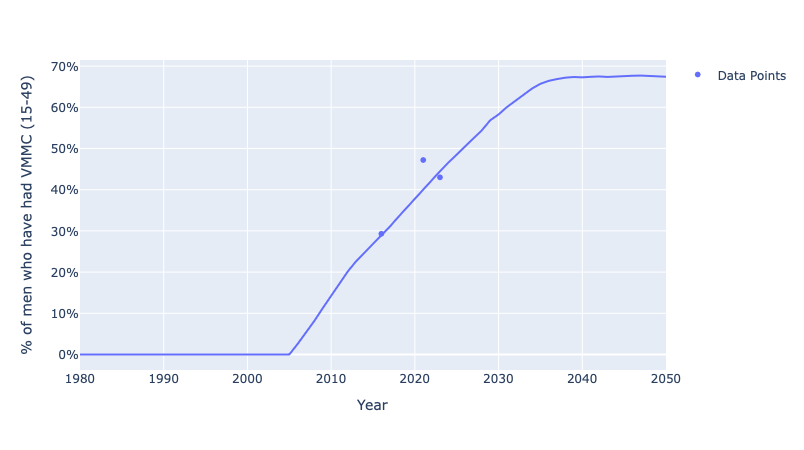

In [48]:
fig = px.line(data_frame=VMMC_wide_df, x='Year', y='Male', width=890, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="% of men who have had VMMC (15-49)",
    legend_title=dict(text=""),
    yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2016, 'Men': 0.293,},
    {'Year': 2021, 'Men': 0.472,},
    {'Year': 2023, 'Men': 0.43,}
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#636EFA', size=6)
    )
)


### Number of people living with HIV, ages 15+

In [24]:
# Prevalence calculator shows everyone infected and not necessarily diagnosed
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        result_df = prevalence_calculator(datalist=datalist, agegroup=[15, 300],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_all_ages_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_all_ages_combined_df['Year'] = prev_all_ages_combined_df['timepoint'].map(timepoint_to_year)
prev_all_ages_combined_df['Gender'] = prev_all_ages_combined_df['Gender'].map(gender)

In [25]:
number_plwh_df = prev_all_ages_combined_df.groupby(['Gender','Year']).agg(
            number_plwh=('sum_cases', 'mean')  # Average number for each gender
        ).reset_index()

number_plwh_df['number_plwh'] = number_plwh_df['number_plwh'] 
number_plwh_df['Actual_number_plwh'] = round(number_plwh_df['number_plwh']*scaling_factor)

In [26]:
number_plwh_wide_df = number_plwh_df.pivot(index='Year', columns='Gender', values='Actual_number_plwh').reset_index()
number_plwh_wide_df.columns.name = None  # Remove the name of the columns index

In [52]:
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)

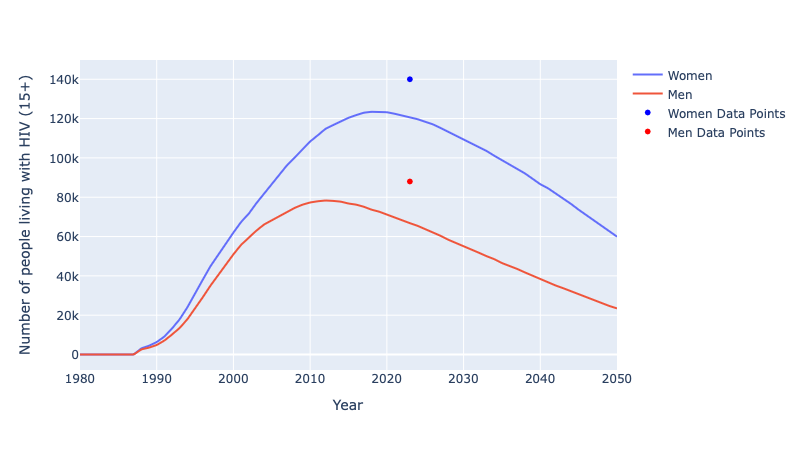

In [27]:
fig = px.line(data_frame=number_plwh_wide_df, x='Year', y=['Women','Men'],width=920, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="Number of people living with HIV (15+)",
    legend_title=dict(text=""),
)

# Data points to add
points = [
    {'Year': 2023, 'Women': 140000, 'Men': 88000, 'Total': 220000},
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points',
        marker=dict(color='red', size=6)
    )
)


fig.show()

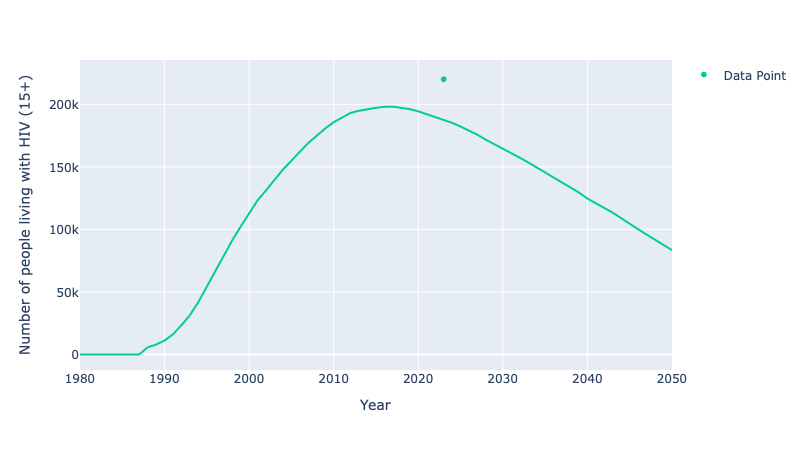

In [28]:
fig = px.line(data_frame=number_plwh_wide_df, x='Year', y='Total',width=980, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="Number of people living with HIV (15+)",
    legend_title=dict(text=""),
)
# Update the line color to green
fig.update_traces(line=dict(color='#00CC96'))

# Data points to add
points = [
    {'Year': 2023, 'Total': 220000,}
    # Add more points as needed
]

fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Point',
        marker=dict(color='#00CC96', size=6)
    )
)
fig.show()

### Proportion diagnosed age 15-49

In [55]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = proportion_diagnosed_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_diag_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_diag_combined_df['Year'] = prev_diag_combined_df['timepoint'].map(timepoint_to_year)
prev_diag_combined_df['Gender'] = prev_diag_combined_df['Gender'].map(gender)

In [56]:
diagnosed_df = prev_diag_combined_df.groupby(['Gender','Year']).agg(
            sum_cases=('sum_cases', 'sum'),  # Average pop for each gender
            sum_diagnosed = ('sum_diagnosed','sum')
        ).reset_index()

diagnosed_df['propdiagnosed'] = diagnosed_df['sum_diagnosed']/diagnosed_df['sum_cases']

In [57]:
diagnosed_wide_df = diagnosed_df.pivot(index='Year', columns='Gender', values='propdiagnosed').reset_index()
diagnosed_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)

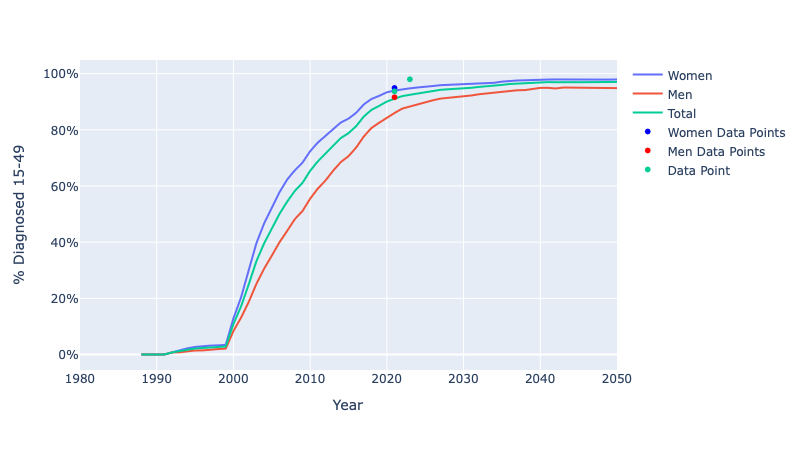

In [58]:
fig = px.line(data_frame=diagnosed_wide_df, x='Year', y=['Women','Men','Total'],width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% Diagnosed 15-49",
    legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2021, 'Women': 0.949, 'Men': 0.916, 'Total': 0.937},
    {'Year': 2023, 'Women': np.nan, 'Men': np.nan, 'Total': 0.98},
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Point',
        marker=dict(color='#00CC96', size=6)
    )
)

fig.show()

### HIV-related deaths 15+

In [59]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        agegroup = [0, 200]
        result_df = AIDS_deaths_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
AIDS_deaths_combined_df = pd.concat(dfs, ignore_index=True)
AIDS_deaths_combined_df = AIDS_deaths_combined_df.dropna(subset=['Gender'])
# Replace timepoint with years, gender with actual gender string
AIDS_deaths_combined_df['Year'] = AIDS_deaths_combined_df['timepoint'].map(timepoint_to_year)
AIDS_deaths_combined_df['Gender'] = AIDS_deaths_combined_df['Gender'].map(gender)

In [60]:
AIDS_deaths_df = AIDS_deaths_combined_df.groupby(['Gender','Year']).agg(
            sum_AIDSDeath=('sum_AIDSDeath', 'mean')  # Average pop for each gender
        ).reset_index()

AIDS_deaths_df['sum_AIDSDeath_actual'] = round(AIDS_deaths_df['sum_AIDSDeath']*scaling_factor)

In [61]:
AIDS_deaths_wide_df = AIDS_deaths_df.pivot(index='Year', columns='Gender', values='sum_AIDSDeath_actual').reset_index()
AIDS_deaths_wide_df.columns.name = None  # Remove the name of the columns index

In [62]:
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)

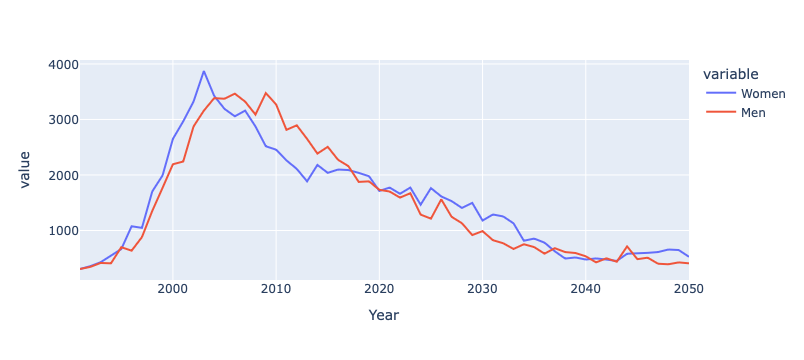

In [63]:
px.line(data_frame=AIDS_deaths_wide_df, x='Year', y=['Women','Men'])

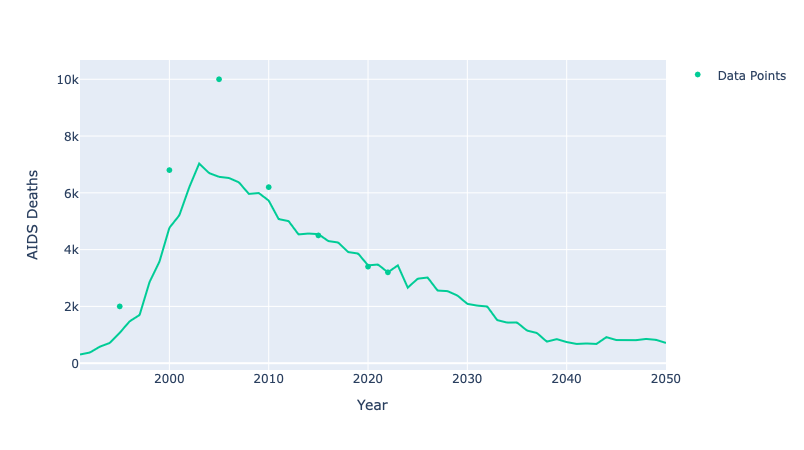

In [64]:
fig = px.line(data_frame=AIDS_deaths_wide_df, x='Year', y='Total',width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="AIDS Deaths"
)

fig.update_traces(line=dict(color='#00CC96'))

# Data points to add
points = [
    {'Year': 1995, 'Total': 2000},
    {'Year': 2000, 'Total': 6800},
    {'Year': 2005, 'Total': 10000},
    {'Year': 2010, 'Total': 6200},
    {'Year': 2015, 'Total': 4500},
    {'Year': 2020, 'Total': 3400},
    {'Year': 2022, 'Total': 3200},
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

### HIV incidence as new infections per 1000 uninfected population  (15-24)

In [29]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=[15,25],timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df_24 = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df_24['Year'] = inc_combined_df_24['timepoint'].map(timepoint_to_year)
inc_combined_df_24['Gender'] = inc_combined_df_24['Gender'].map(gender)

In [30]:
incidence_df_24 = inc_combined_df_24.groupby(['Gender','Year']).agg(
            sum_exposure_time=('sum_exposure_time', 'sum'),  
            sum_incident_cases = ('sum_incident_cases', 'sum')
        ).reset_index()

incidence_df_24['incidence']  = incidence_df_24['sum_incident_cases']/incidence_df_24['sum_exposure_time']
incidence_df_24['incidence'] = round(incidence_df_24['incidence'] * 1000, 3)
incidence_df_24

Gender    Year  sum_exposure_time  sum_incident_cases  incidence
0      Men  1981.0        5797.875732                   0      0.000
1      Men  1982.0        6104.550299                   0      0.000
2      Men  1983.0        6408.525899                   0      0.000
3      Men  1984.0        6697.205514                   0      0.000
4      Men  1985.0        7021.218019                   0      0.000
..     ...     ...                ...                 ...        ...
205  Women  2046.0       15082.612940                  18      1.193
206  Women  2047.0       15512.567994                  17      1.096
207  Women  2048.0       15948.612272                   6      0.376
208  Women  2049.0       16311.057421                   2      0.123
209  Women  2050.0       16768.176013                   9      0.537

[210 rows x 5 columns]

In [67]:
incidence_24_wide_df = incidence_df_24.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_24_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)
    incidence_24_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000 15-24', index=False)

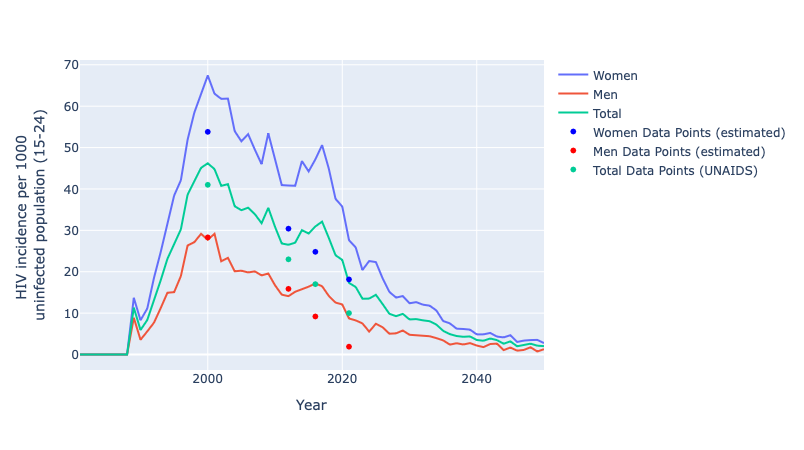

In [68]:
fig = px.line(data_frame=incidence_24_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-24)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': 53.8, 'Men': 28.3,'Total': 41},
    {'Year': 2012, 'Women': 30.4, 'Men': 15.86, 'Total': 23}, 
    {'Year': 2016, 'Women': 24.81, 'Men': 9.19, 'Total': 17}, 
    {'Year': 2021, 'Women': 18.14, 'Men': 1.89,'Total': 10}, 
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

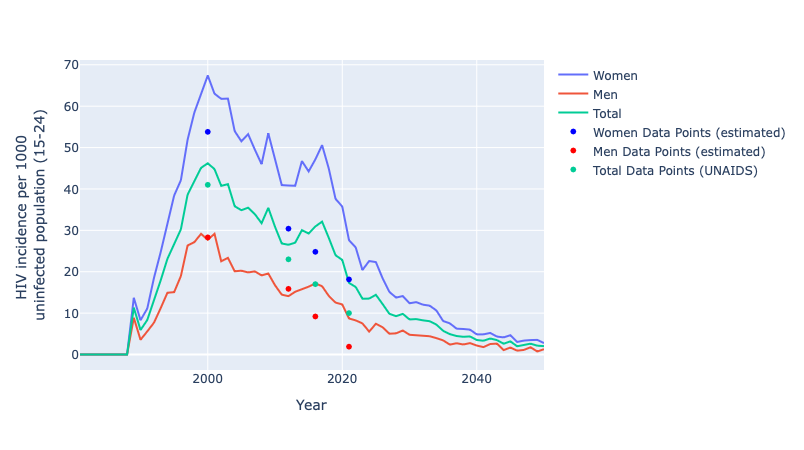

In [69]:
fig = px.line(data_frame=incidence_24_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-24)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': 53.8, 'Men': 28.3,'Total': 41},
    {'Year': 2012, 'Women': 30.4, 'Men': 15.86, 'Total': 23}, 
    {'Year': 2016, 'Women': 24.81, 'Men': 9.19, 'Total': 17}, 
    {'Year': 2021, 'Women': 18.14, 'Men': 1.89,'Total': 10}, 
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

### New HIV infections age 15-24 pop

In [70]:
new_infections_df_24 = inc_combined_df_24.groupby(['Gender','Year']).agg(
            sum_incident_cases=('sum_incident_cases', 'mean')  # Average pop for each gender
        ).reset_index()

new_infections_df_24['sum_incident_cases_actual'] = round(new_infections_df_24['sum_incident_cases']*scaling_factor)

In [71]:
new_infections_24_wide_df = new_infections_df_24.pivot(index='Year', columns='Gender', values='sum_incident_cases_actual').reset_index()
new_infections_24_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)
    incidence_24_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000 15-24', index=False)
    new_infections_24_wide_df.to_excel(writer, sheet_name='New HIV infections 15-24', index=False)

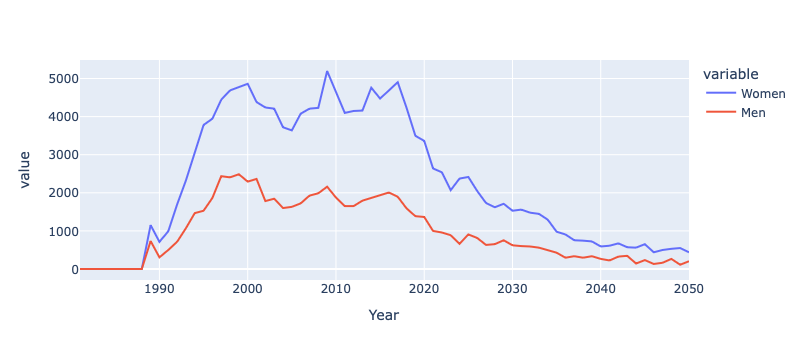

In [72]:
px.line(data_frame=new_infections_24_wide_df, x='Year', y=['Women','Men'])

### Age mixing patterns

In [68]:
datalist = loaded_data['model30']

In [69]:
datalist['itable'][['formation.hazard.agegapry.gap_agescale_man','formation.hazard.agegapry.gap_agescale_woman',
                    'person.agegap.man.dist.normal.mu','person.agegap.man.dist.normal.sigma',
                    'person.agegap.woman.dist.normal.mu','person.agegap.woman.dist.normal.sigma',
                    'formation.hazard.agegapry.gap_factor_man_exp','formation.hazard.agegapry.gap_factor_woman_exp',
                    'formation.hazard.agegapry.baseline',
                    'formation.hazard.agegapry.numrel_man',
                    'formation.hazard.agegapry.numrel_woman',
                    'formation.hazard.agegapry.meanage',
                    'formation.hazard.agegapry.gap_factor_man_age',
                    'formation.hazard.agegapry.gap_factor_woman_age']]

formation.hazard.agegapry.gap_agescale_man   
0                                     0.253455  \
1                                     0.253455   
2                                     0.253455   
3                                     0.253455   
4                                     0.253455   
5                                     0.253455   
6                                     0.253455   
7                                     0.253455   
8                                     0.253455   
9                                     0.253455   
10                                    0.253455   
11                                    0.253455   
12                                    0.253455   
13                                    0.253455   
14                                    0.253455   

    formation.hazard.agegapry.gap_agescale_woman   
0                                       0.286998  \
1                                       0.286998   
2                                       0.286998   
3                                       0.286998   
4                                       0.286998   
5                                       0.286998   
6                                       0.286998   
7                                       0.286998   
8                                       0.286998   
9                                       0.286998   
10                                      0.286998   
11                                      0.286998   
12                                      0.286998   
13                                      0.286998   
14                                      0.286998   

    person.agegap.man.dist.normal.mu  person.agegap.man.dist.normal.sigma   
0                          -1.891919                              4.10064  \
1                          -1.891919                              4.10064   
2                          -1.891919                              4.10064   
3                          -1.891919                              4.10064   
4                          -1.891919                              4.10064   
5                          -1.891919                              4.10064   
6                          -1.891919                              4.10064   
7                          -1.891919                              4.10064   
8                          -1.891919                              4.10064   
9                          -1.891919                              4.10064   
10                         -1.891919                              4.10064   
11                         -1.891919                              4.10064   
12                         -1.891919                              4.10064   
13                         -1.891919                              4.10064   
14                         -1.891919                              4.10064   

    person.agegap.woman.dist.normal.mu  person.agegap.woman.dist.normal.sigma   
0                            -1.091896                               3.091794  \
1                            -1.091896                               3.091794   
2                            -1.091896                               3.091794   
3                            -1.091896                               3.091794   
4                            -1.091896                               3.091794   
5                            -1.091896                               3.091794   
6                            -1.091896                               3.091794   
7                            -1.091896                               3.091794   
8                            -1.091896                               3.091794   
9                            -1.091896                               3.091794   
10                           -1.091896                               3.091794   
11                           -1.091896                               3.091794   
12                           -1.091896                               3.091794   
13 

In [70]:
df = agemix_df_maker(datalist=datalist)
df_unique = df.drop_duplicates(subset='relid')
df_unique

ID Gender        TOB            TOD   IDF   IDM        TODebut   
14786     1   male -23.343712  30.4414571109    -1    -1   0.0000000000  \
14781     1   male -23.343712  30.4414571109    -1    -1   0.0000000000   
14787     1   male -23.343712  30.4414571109    -1    -1   0.0000000000   
14788     1   male -23.343712  30.4414571109    -1    -1   0.0000000000   
14789     1   male -23.343712  30.4414571109    -1    -1   0.0000000000   
...     ...    ...        ...            ...   ...   ...            ...   
3519   5958   male  55.915568            inf  2250  3094  70.9155676895   
3520   5958   male  55.915568            inf  2250  3094  70.9155676895   
3521   5958   male  55.915568            inf  2250  3094  70.9155676895   
3522   5958   male  55.915568            inf  2250  3094  70.9155676895   
3523   5958   male  55.915568            inf  2250  3094  70.9155676895   

          FormEag    FormEagMSM     InfectTime  ...  CD4atDeath   FormTime   
14786   98.336826  0.0000000000  18.5108508207  ...    20.89737  15.836877  \
14781   98.336826  0.0000000000  18.5108508207  ...    20.89737   0.117542   
14787   98.336826  0.0000000000  18.5108508207  ...    20.89737  22.579058   
14788   98.336826  0.0000000000  18.5108508207  ...    20.89737  15.719925   
14789   98.336826  0.0000000000  18.5108508207  ...    20.89737  26.790021   
...           ...           ...            ...  ...         ...        ...   
3519   167.211056  0.0000000000            inf  ...    -1.00000  70.959936   
3520   167.211056  0.0000000000            inf  ...    -1.00000  70.920124   
3521   167.211056  0.0000000000            inf  ...    -1.00000  70.915570   
3522   167.211056  0.0000000000            inf  ...    -1.00000  70.921588   
3523   167.211056  0.0000000000            inf  ...    -1.00000  70.919651   

             DisTime     AgeGap  MSM  CondomUsingFormation     relid   
14786  30.4414571109  10.003753  0.0                   0.0     11077  \
14781  15.5709113583  -1.385740  0.0                   0.0     11217   
14787  30.4414571109   6.437916  0.0                   0.0     11232   
14788  30.4414571109   5.050336  0.0                   0.0     11379   
14789  30.4414571109   7.812348  0.0                   0.0     11507   
...              ...        ...  ...                   ...       ...   
3519             inf  -1.674622  0.0                   1.0  59585802   
3520             inf  -1.149783  0.0                   1.0  59585844   
3521             inf  -0.999233  0.0                   1.0  59585860   
3522             inf  -0.944257  0.0                   1.0  59585867   
3523             inf  -0.304744  0.0                   0.0  59585925   

      episodeorder  agerelform  pagerelform  
14786          1.0   39.180589    29.176836  
14781          1.0   23.461254    24.846994  
14787          1.0   45.922770    39.484854  
14788          1.0   39.063637    34.013301  
14789          1.0   50.133733    42.321384  
...            ...         ...          ...  
3519           1.0   15.044368    16.718990  
3520           1.0   15.004557    16.154340  
3521           1.0   15.000002    15.999235  
3522           1.0   15.006021    15.950277  
3523           1.0   15.004083    15.308827  

[20071 rows x 30 columns]

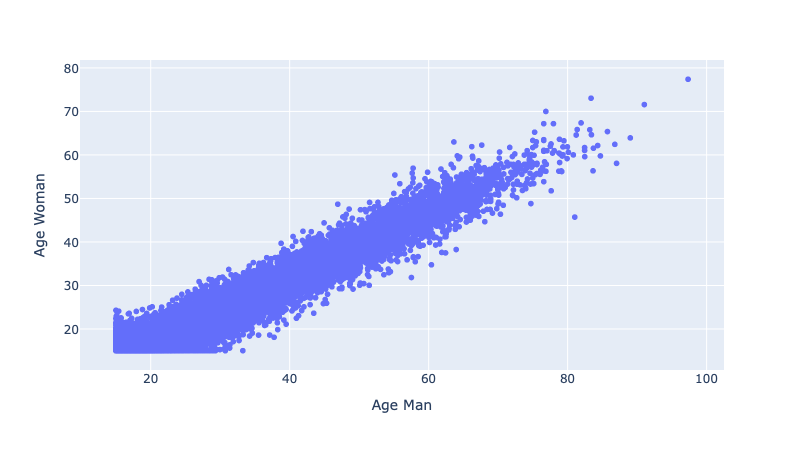

In [71]:
fig = px.scatter(df_unique, x='agerelform', y='pagerelform', width=890, height=450)
fig.update_layout(
    xaxis_title="Age Man", yaxis_title="Age Woman"
)
fig.show()

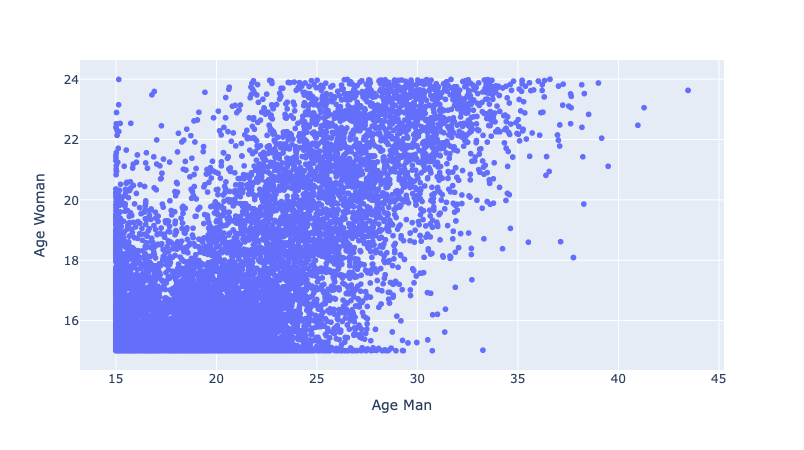

In [72]:
# 15-24yrs
df_agyw = df.query('Gender == "Women" and agerelform <= 24')
fig = px.scatter(df_agyw, x='pagerelform', y='agerelform', width=890, height=450)
fig.update_layout(
    xaxis_title="Age Man", yaxis_title="Age Woman"
)
fig.show()

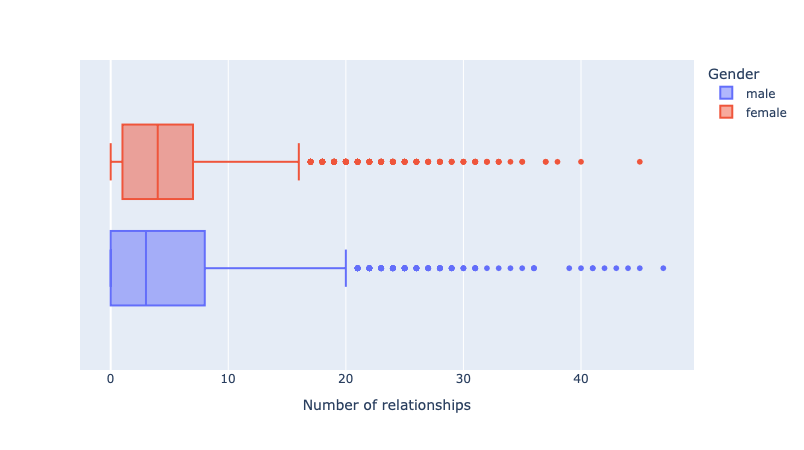

In [73]:
# Relationship counts general
# Group by 'id' and count unique 'relid'
relationship_counts = df.groupby(['ID','Gender'])['relid'].nunique().reset_index(name='relationship_counts')

fig = px.box(relationship_counts, x='relationship_counts',color='Gender',  width=890, height=450)
fig.update_layout(
    xaxis_title="Number of relationships", 
)
fig.show()

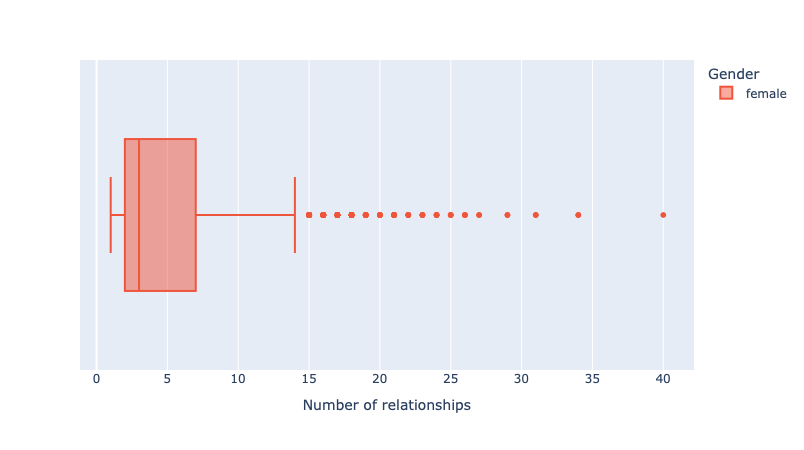

In [74]:
# Relationship counts for 15-24
relationship_counts = df.query('Gender == "Women" and agerelform <= 24').groupby(['ID','Gender'])['relid'].nunique().reset_index(name='relationship_counts')
fig = px.box(relationship_counts, x='relationship_counts',color='Gender', color_discrete_sequence=['#EF553B'], width=890, height=450)
fig.update_layout(
    xaxis_title="Number of relationships", 
)
fig.show()

### Future Scenario VMMC

In [174]:
### Read the data

# Specify the folder path containing pickle files
folder_path = 'Calibration/best_of_pyABC'

# Define the pattern to match for pickle files
file_pattern = 'datalist_2030_vmmc_seed*.pkl'

# Find all matching files
file_paths = glob.glob(os.path.join(folder_path, file_pattern))

# Initialize an empty dictionary to store loaded data
loaded_data_2030 = {}

# Load each pickle file
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        # Extract the seed number from the file name
        seed_number = int(file_path.split('seed')[1].split('.')[0])
        # Load the pickle file and store in the dictionary
        loaded_data_2030[f'model{seed_number}'] = pickle.load(f)

In [175]:
loaded_data_2030.keys()

dict_keys(['model23', 'model22', 'model20', 'model21', 'model8', 'model19', 'model25', 'model24', 'model30', 'model18', 'model9', 'model26', 'model27', 'model7', 'model16', 'model17', 'model6', 'model4', 'model15', 'model29', 'model28', 'model14', 'model5', 'model1', 'model10', 'model11', 'model2', 'model13', 'model12', 'model3'])

In [176]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = vmmc_calculator(datalist=datalist, agegroup=[15,50],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VMMC_combined_df_2030 = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
VMMC_combined_df_2030['Year'] = VMMC_combined_df_2030['timepoint'].map(timepoint_to_year)

In [177]:
VMMC_df_2030 = VMMC_combined_df_2030.groupby(['Gender','Year']).agg(
            popsize=('popsize', 'mean'),  # sum acros all models each gender
            sum_circumcised = ('sum_circumcised', 'mean'),
            popsize_all=('popsize', 'sum'),  # sum acros all models each gender
            sum_circumcised_all = ('sum_circumcised', 'sum'),
            vmmcprevalence = ('vmmcprevalence','mean')
        ).reset_index()

VMMC_df_2030['vmmcprevalence_']  = round(VMMC_df_2030['sum_circumcised_all']/VMMC_df_2030['popsize_all'],4)

VMMC_df_2030['vmmcprevalence'] = round(VMMC_df_2030['vmmcprevalence'],4)

In [178]:
VMMC_wide_df_2030 = VMMC_df_2030.pivot(index='Year', columns='Gender', values='vmmcprevalence_').reset_index()
VMMC_wide_df_2030.columns.name = None  # Remove the name of the columns index

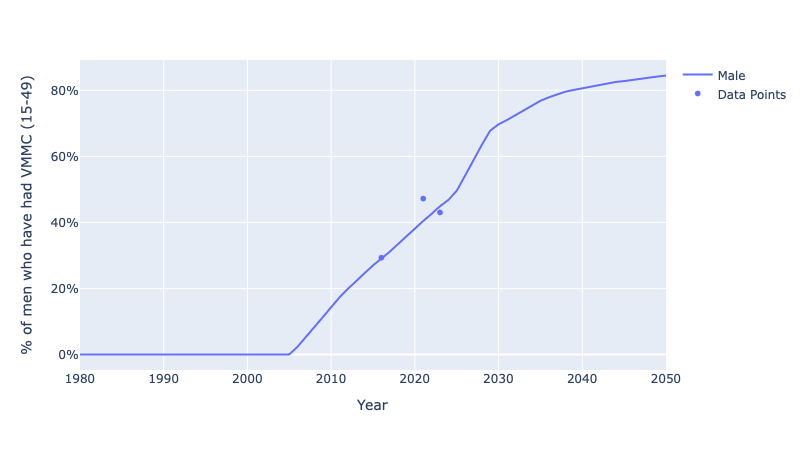

In [180]:
fig = px.line(data_frame=VMMC_wide_df_2030, x='Year', y=['Male'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="% of men who have had VMMC (15-49)",
    legend_title=dict(text=""),
    yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2016, 'Men': 0.293,},
    {'Year': 2021, 'Men': 0.472,},
    {'Year': 2023, 'Men': 0.43,}
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#636EFA', size=6)
    )
)

In [181]:
VMMC_wide_df_status_quo_future = pd.merge(VMMC_wide_df, VMMC_wide_df_2030, 
                                          how='left', 
                                          on='Year')

VMMC_wide_df_status_quo_future.rename(columns={'Male_x': 'Status quo',
                             'Male_y': 'Future scenario'}, inplace=True)

VMMC_wide_df_status_quo_future

Year  Status quo  Future scenario
0   1980      0.0000           0.0000
1   1981      0.0000           0.0000
2   1982      0.0000           0.0000
3   1983      0.0000           0.0000
4   1984      0.0000           0.0000
..   ...         ...              ...
66  2046      0.6765           0.8304
67  2047      0.6769           0.8347
68  2048      0.6759           0.8383
69  2049      0.6761           0.8420
70  2050      0.6741           0.8447

[71 rows x 3 columns]

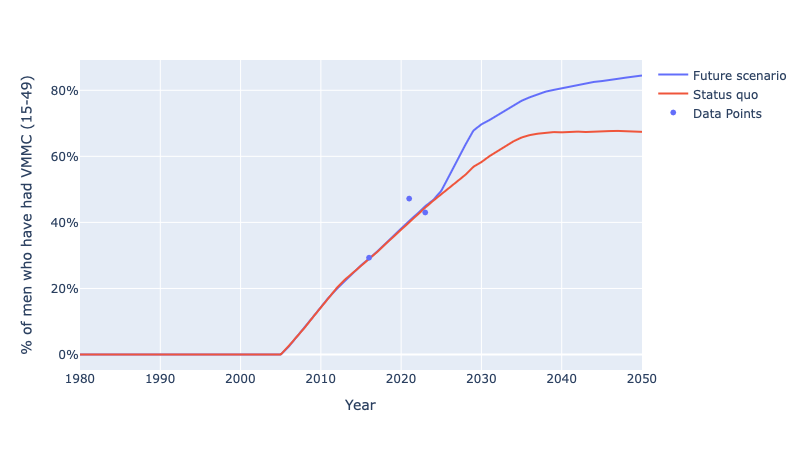

In [182]:
fig = px.line(data_frame=VMMC_wide_df_status_quo_future, x='Year', y=['Future scenario','Status quo'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="% of men who have had VMMC (15-49)",
    legend_title=dict(text=""),
    yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2016, 'Men': 0.293,},
    {'Year': 2021, 'Men': 0.472,},
    {'Year': 2023, 'Men': 0.43,}
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#636EFA', size=6)
    )
)


In [206]:
## for cost
import math
math.ceil(VMMC_df.query('Year == 2030')['sum_circumcised'].iloc[0] * scaling_factor)

223895

In [207]:
math.ceil(VMMC_df_2030.query('Year == 2030')['sum_circumcised'].iloc[0] * scaling_factor)

258921

In [209]:
258921 - 223895

35026

In [210]:
35026*50

1751300

#### HIV incidence as new infections per 1000

In [137]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df['Year'] = inc_combined_df['timepoint'].map(timepoint_to_year)
inc_combined_df['Gender'] = inc_combined_df['Gender'].map(gender)

In [138]:
incidence_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_exposure_time=('sum_exposure_time', 'sum'),  
            sum_incident_cases = ('sum_incident_cases', 'sum')
        ).reset_index()

incidence_df['incidence']  = incidence_df['sum_incident_cases']/incidence_df['sum_exposure_time']
incidence_df['incidence'] = round(incidence_df['incidence'] * 1000, 3)
incidence_df

Gender    Year  sum_exposure_time  sum_incident_cases  incidence
0      Men  1981.0       13160.693732                   0      0.000
1      Men  1982.0       13746.512417                   0      0.000
2      Men  1983.0       14346.957839                   0      0.000
3      Men  1984.0       14934.073174                   0      0.000
4      Men  1985.0       15572.250722                   0      0.000
..     ...     ...                ...                 ...        ...
205  Women  2046.0       40118.323798                   9      0.224
206  Women  2047.0       40962.387769                  10      0.244
207  Women  2048.0       41828.438270                   4      0.096
208  Women  2049.0       42686.873881                   5      0.117
209  Women  2050.0       43629.605009                   1      0.023

[210 rows x 5 columns]

In [139]:
incidence_wide_df = incidence_df.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_wide_df.columns.name = None  # Remove the name of the columns index

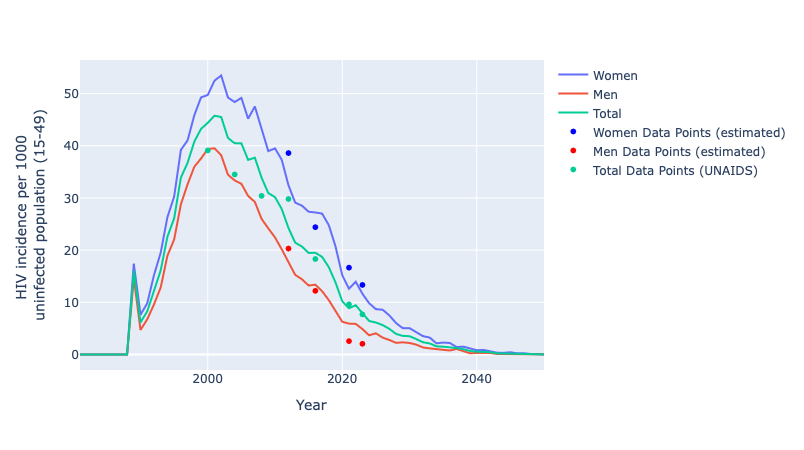

In [140]:
fig = px.line(data_frame=incidence_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-49)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': np.nan, 'Men': np.nan,'Total': 39.1},
    {'Year': 2004, 'Women': np.nan, 'Men': np.nan, 'Total': 34.5},
    {'Year': 2008, 'Women': np.nan, 'Men': np.nan, 'Total': 30.4},
    {'Year': 2012, 'Women': 38.6, 'Men': 20.3, 'Total': 29.8}, #shims1 16.5:31.4
    {'Year': 2016, 'Women': 24.4, 'Men': 12.2, 'Total': 18.3}, #shims2 9.9:19.9
    {'Year': 2021, 'Women': 16.64, 'Men': 2.56,'Total': 9.6}, #shims3 2:14.5 Total 7.7
    {'Year': 2023, 'Women': 13.33, 'Men': 2.05, 'Total': 7.69}, #UNAIDS
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

### Future Scenario PrEP (Ever taken prep general population 15+)

#### status quo 

In [244]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        result_df = prep_users_calculator_ever(datalist=datalist, agegroup=[15,300],timepoint=timepoint)
        result_df['timepoint'] = timepoint-1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prep_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prep_combined_df['Year'] = prep_combined_df['timepoint'].map(timepoint_to_year)
prep_combined_df['Gender'] = prep_combined_df['Gender'].map(gender)

In [246]:
prep_df = prep_combined_df.groupby(['Gender','Year']).agg(
            popsize = ('popsize', 'mean'),
            sum_prep_users = ('sum_prep_users','mean'),
            popsize_all = ('popsize', 'sum'),
            sum_prep_users_all = ('sum_prep_users','sum'),
            #prep_users_prevalence=('prep_users_prevalence', 'mean')  # Average pop for each gender
        ).reset_index()

prep_df['prep_users_prevalence'] = prep_df['sum_prep_users_all']/prep_df['popsize_all']

In [247]:
prep_wide_df = prep_df.pivot(index='Year', columns='Gender', values='prep_users_prevalence').reset_index()
prep_wide_df.columns.name = None  # Remove the name of the columns index

In [248]:
prep_wide_df

Year       Men     Total     Women
0   1980  0.000000  0.000000  0.000000
1   1981  0.000000  0.000000  0.000000
2   1982  0.000000  0.000000  0.000000
3   1983  0.000000  0.000000  0.000000
4   1984  0.000000  0.000000  0.000000
..   ...       ...       ...       ...
66  2046  0.094635  0.092343  0.090074
67  2047  0.096735  0.094610  0.092506
68  2048  0.098693  0.096549  0.094427
69  2049  0.100597  0.098793  0.097008
70  2050  0.102367  0.100944  0.099533

[71 rows x 4 columns]

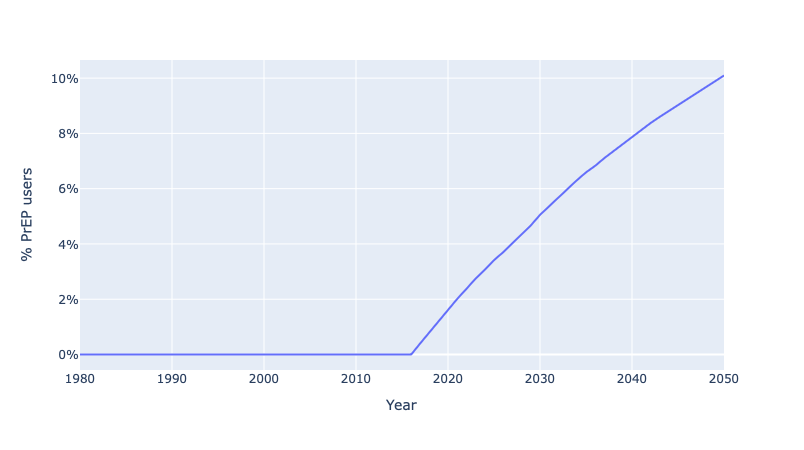

In [249]:
fig = px.line(data_frame=prep_wide_df, x='Year', y='Total', width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% PrEP users", legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Show the plot
fig.show()

#### Future scenario

In [335]:
### Read the data

# Specify the folder path containing pickle files
folder_path = 'Calibration/best_of_pyABC'

# Define the pattern to match for pickle files
file_pattern = 'datalist_2030_prep_seed*.pkl'

# Find all matching files
file_paths = glob.glob(os.path.join(folder_path, file_pattern))

# Initialize an empty dictionary to store loaded data
loaded_data_2030_prep = {}

# Load each pickle file
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        # Extract the seed number from the file name
        seed_number = int(file_path.split('seed')[1].split('.')[0])
        # Load the pickle file and store in the dictionary
        loaded_data_2030_prep[f'model{seed_number}'] = pickle.load(f)

In [230]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_prep.items():
    for timepoint in evaluation_timepoints:
        result_df = prep_users_calculator_ever(datalist=datalist, agegroup=[15,300],timepoint=timepoint)
        result_df['timepoint'] = timepoint-1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prep_combined_df_2030 = pd.concat(dfs, ignore_index=True)
# Replace timepoint with years, gender with actual gender string
prep_combined_df_2030['Year'] = prep_combined_df_2030['timepoint'].map(timepoint_to_year)
prep_combined_df_2030['Gender'] = prep_combined_df_2030['Gender'].map(gender)

In [231]:
prep_df_2030 = prep_combined_df_2030.groupby(['Gender','Year']).agg(
            popsize = ('popsize', 'mean'),
            sum_prep_users = ('sum_prep_users','mean'),
            popsize_all = ('popsize', 'sum'),
            sum_prep_users_all = ('sum_prep_users','sum'),
            #prep_users_prevalence=('prep_users_prevalence', 'mean')  # Average pop for each gender
        ).reset_index()

prep_df_2030['prep_users_prevalence'] = prep_df_2030['sum_prep_users_all']/prep_df_2030['popsize_all']

In [232]:
prep_wide_df_2030 = prep_df_2030.pivot(index='Year', columns='Gender', values='prep_users_prevalence').reset_index()
prep_wide_df_2030.columns.name = None  # Remove the name of the columns index

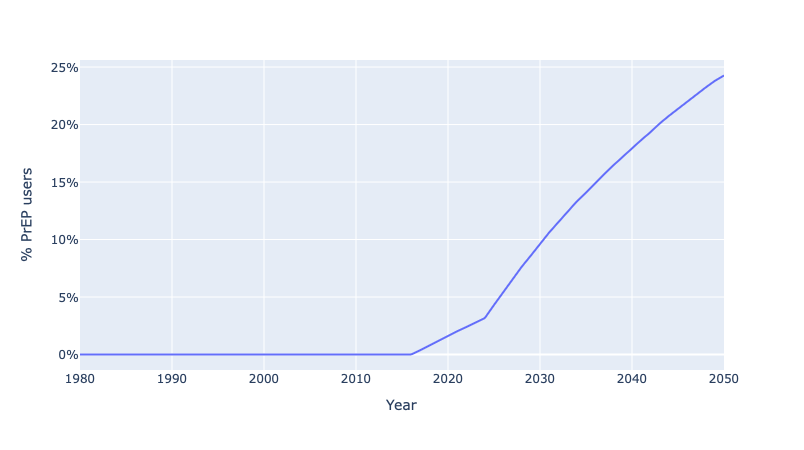

In [234]:
fig = px.line(data_frame=prep_wide_df_2030, x='Year', y='Total', width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% PrEP users", legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Show the plot
fig.show()

In [250]:
prep_wide_df_status_quo_future = pd.merge(prep_wide_df, prep_wide_df_2030, 
                                          how='left', 
                                          on='Year')

prep_wide_df_status_quo_future.rename(columns={'Total_x': 'Status quo',
                             'Total_y': 'Future scenario'}, inplace=True)

prep_wide_df_status_quo_future

Year     Men_x  Status quo   Women_x     Men_y  Future scenario   Women_y
0   1980  0.000000    0.000000  0.000000  0.000000         0.000000  0.000000
1   1981  0.000000    0.000000  0.000000  0.000000         0.000000  0.000000
2   1982  0.000000    0.000000  0.000000  0.000000         0.000000  0.000000
3   1983  0.000000    0.000000  0.000000  0.000000         0.000000  0.000000
4   1984  0.000000    0.000000  0.000000  0.000000         0.000000  0.000000
..   ...       ...         ...       ...       ...              ...       ...
66  2046  0.094635    0.092343  0.090074  0.222398         0.219452  0.216494
67  2047  0.096735    0.094610  0.092506  0.228105         0.225704  0.223298
68  2048  0.098693    0.096549  0.094427  0.234940         0.232187  0.229432
69  2049  0.100597    0.098793  0.097008  0.240531         0.237958  0.235395
70  2050  0.102367    0.100944  0.099533  0.244873         0.242647  0.240433

[71 rows x 7 columns]

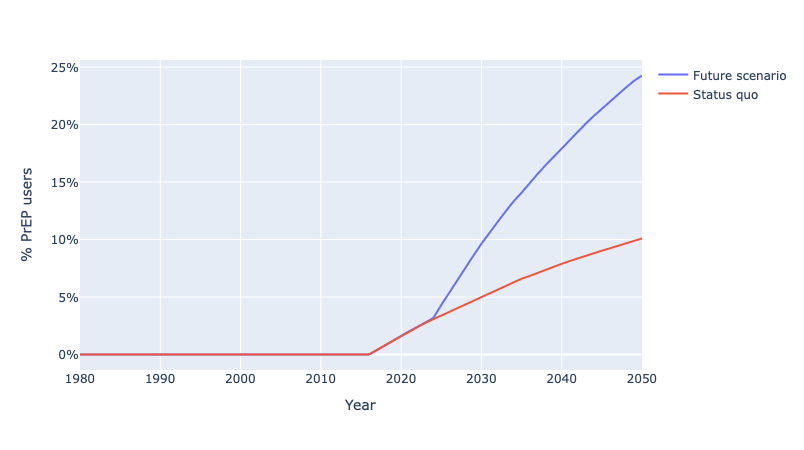

In [251]:
fig = px.line(data_frame=prep_wide_df_status_quo_future, x='Year', y=['Future scenario','Status quo'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="% PrEP users",
    legend_title=dict(text=""),
    yaxis_tickformat='.0%'
)


In [260]:
# cost for prep- compute person years on prep
prep_users_calculator(datalist=loaded_data_2030_prep['model1'], agegroup=[15,300],timewindow=[40,41])

Gender  popsize  sum_prep_users  prep_users_prevalence   
0      0     1113              10               0.008985  \
1      1     1181               3               0.002540   
2  Total     2294              13               0.005667   

   prep_users_prevalence.95.ll  prep_users_prevalence.95.ul  
0                     0.004317                     0.016461  
1                     0.000524                     0.007405  
2                     0.003021                     0.009671

###### prep person years

In [326]:
def person_years_on_prep(datalist, agegroup, timewindow):

    # Extract time window boundaries
    lwr_time = timewindow[0]
    upr_time = timewindow[1]

    events = datalist['etable']
    prep_use_events = events[events['eventname'] == 'Prep_treatment_P1'] 
    prep_use_events = prep_use_events.rename(columns={'eventtime':'Prep_Start_Date'})

    # Retain only those who are in the specified age groups
    prep_use_events = prep_use_events[
            (prep_use_events['p1age'] >= agegroup[0]) &
            (prep_use_events['p1age'] < agegroup[1])
        ]
    prep_use_events = prep_use_events.reset_index(drop=True)

    prep_drop = events[events['eventname'] == 'PrepDrop']
    prep_drop = prep_drop.rename(columns={'eventtime':'Prep_Stop_Date'})

    # Step 1: Merge the two tables on Patient_ID
    merged_table = pd.merge(prep_use_events, prep_drop, on='p1name', how='left')

    # Step 2: Filter to keep only the rows where Prep_Stop_Date is after Prep_Start_Date
    merged_table = merged_table[merged_table['Prep_Stop_Date'] >= merged_table['Prep_Start_Date']]

    # Step 3: Sort by Patient_ID, Prep_Start_Date, and Prep_Stop_Date
    merged_table = merged_table.sort_values(by=['p1name', 'Prep_Start_Date', 'Prep_Stop_Date'])

    # Step 4: Group by Patient_ID and Prep_Start_Date, then take the first matching Prep_Stop_Date
    result = merged_table.groupby(['p1name', 'Prep_Start_Date']).first().reset_index()

    # Step 5: Merge this result back with the original prep_start_times table to get the final table
    prep_start_times_with_end = pd.merge(prep_use_events, 
                                        result[['p1name', 'Prep_Start_Date', 'Prep_Stop_Date']], 
                                        on=['p1name', 'Prep_Start_Date'], how='left')

    # Rename the Prep_Stop_Date column to Prep_End_Date
    prep_start_times_with_end = prep_start_times_with_end.rename(columns={'Prep_Stop_Date': 'Prep_End_Date'})

    prep_start_times_with_end = prep_start_times_with_end[(prep_start_times_with_end['Prep_Start_Date'] >= lwr_time) & (prep_start_times_with_end['Prep_Start_Date'] <= upr_time)]
    prep_start_times_with_end['New_Prep_End_Date'] = np.where(
    prep_start_times_with_end['Prep_End_Date'].notna(),
    np.minimum(prep_start_times_with_end['Prep_End_Date'], upr_time),
    upr_time)
    
    prep_start_times_with_end['duration'] = prep_start_times_with_end['New_Prep_End_Date'] - prep_start_times_with_end['Prep_Start_Date']
    total_person_years_on_prep = prep_start_times_with_end['duration'].sum()
    return total_person_years_on_prep

In [344]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    result_df = person_years_on_prep(datalist=datalist, agegroup=[15,300], timewindow=[45,51])*scaling_factor

    # Append the resulting dataframe to the list
    dfs.append(result_df)
# mean
person_years_on_prep_status_quo = np.mean(dfs)
person_years_on_prep_status_quo

49427.74207319308

In [343]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_prep.items():
    result_df = person_years_on_prep(datalist=datalist, agegroup=[15,300], timewindow=[45,51])*scaling_factor

    # Append the resulting dataframe to the list
    dfs.append(result_df)
# mean
person_years_on_prep_scale_up = np.mean(dfs)
person_years_on_prep_scale_up

142091.34250755722

In [348]:
(142091.34 - 49427.74)

92663.6

In [347]:
200*(142091.34 - 49427.74)

18532720.0

#### HIV incidence as new infections per 1000

In [252]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_prep.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df['Year'] = inc_combined_df['timepoint'].map(timepoint_to_year)
inc_combined_df['Gender'] = inc_combined_df['Gender'].map(gender)

In [253]:
incidence_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_exposure_time=('sum_exposure_time', 'sum'),  
            sum_incident_cases = ('sum_incident_cases', 'sum')
        ).reset_index()

incidence_df['incidence']  = incidence_df['sum_incident_cases']/incidence_df['sum_exposure_time']
incidence_df['incidence'] = round(incidence_df['incidence'] * 1000, 3)

In [254]:
incidence_wide_df = incidence_df.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_wide_df.columns.name = None  # Remove the name of the columns index

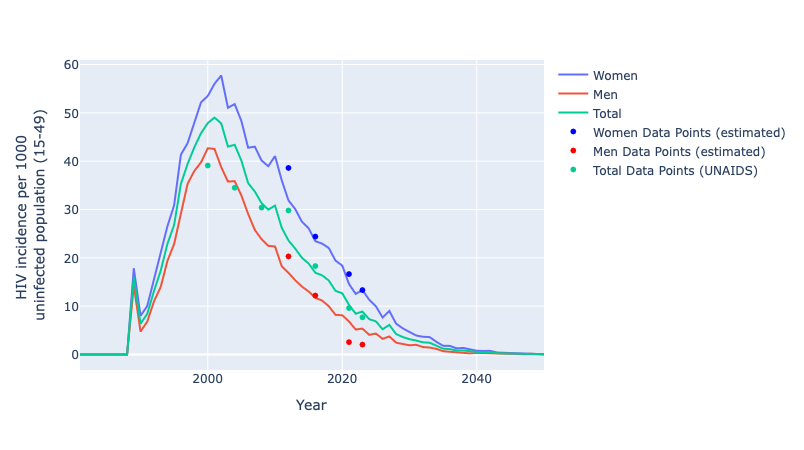

In [255]:
fig = px.line(data_frame=incidence_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-49)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': np.nan, 'Men': np.nan,'Total': 39.1},
    {'Year': 2004, 'Women': np.nan, 'Men': np.nan, 'Total': 34.5},
    {'Year': 2008, 'Women': np.nan, 'Men': np.nan, 'Total': 30.4},
    {'Year': 2012, 'Women': 38.6, 'Men': 20.3, 'Total': 29.8}, #shims1 16.5:31.4
    {'Year': 2016, 'Women': 24.4, 'Men': 12.2, 'Total': 18.3}, #shims2 9.9:19.9
    {'Year': 2021, 'Women': 16.64, 'Men': 2.56,'Total': 9.6}, #shims3 2:14.5 Total 7.7
    {'Year': 2023, 'Women': 13.33, 'Men': 2.05, 'Total': 7.69}, #UNAIDS
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

In [258]:
100* (6.447  - 4.661)/6.447 

27.702807507367776

In [257]:
100* (2.964 - 1.901 )/2.964 

35.86369770580297

In [256]:
100* (4.548 - 3.163)/4.548 

30.45294635004398

### Future Scenario VMMC and PrEP

In [349]:
### Read the data

# Specify the folder path containing pickle files
folder_path = 'Calibration/best_of_pyABC'

# Define the pattern to match for pickle files
file_pattern = 'datalist_2030_vmmc_prep_seed*.pkl'

# Find all matching files
file_paths = glob.glob(os.path.join(folder_path, file_pattern))

# Initialize an empty dictionary to store loaded data
loaded_data_2030_vmmc_prep = {}

# Load each pickle file
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        # Extract the seed number from the file name
        seed_number = int(file_path.split('seed')[1].split('.')[0])
        # Load the pickle file and store in the dictionary
        loaded_data_2030_vmmc_prep[f'model{seed_number}'] = pickle.load(f)

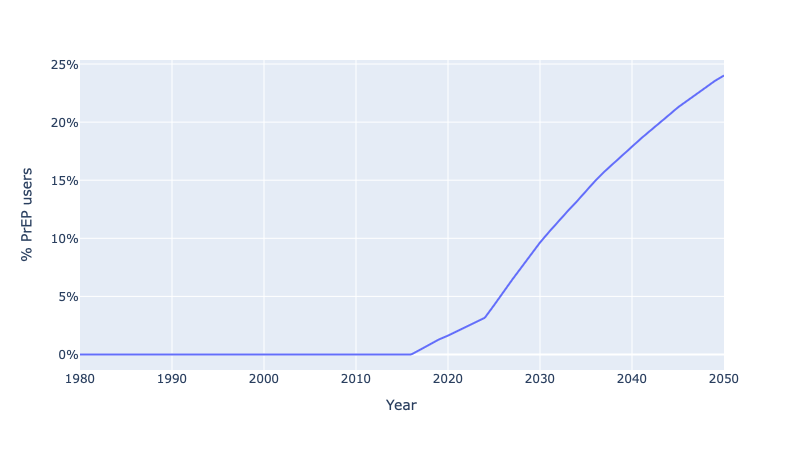

In [351]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_vmmc_prep.items():
    for timepoint in evaluation_timepoints:
        result_df = prep_users_calculator_ever(datalist=datalist, agegroup=[15,300],timepoint=timepoint)
        result_df['timepoint'] = timepoint-1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prep_combined_df_2030 = pd.concat(dfs, ignore_index=True)
# Replace timepoint with years, gender with actual gender string
prep_combined_df_2030['Year'] = prep_combined_df_2030['timepoint'].map(timepoint_to_year)
prep_combined_df_2030['Gender'] = prep_combined_df_2030['Gender'].map(gender)
prep_df_2030 = prep_combined_df_2030.groupby(['Gender','Year']).agg(
            popsize = ('popsize', 'mean'),
            sum_prep_users = ('sum_prep_users','mean'),
            popsize_all = ('popsize', 'sum'),
            sum_prep_users_all = ('sum_prep_users','sum'),
            #prep_users_prevalence=('prep_users_prevalence', 'mean')  # Average pop for each gender
        ).reset_index()
prep_df_2030['prep_users_prevalence'] = prep_df_2030['sum_prep_users_all']/prep_df_2030['popsize_all']
prep_wide_df_2030 = prep_df_2030.pivot(index='Year', columns='Gender', values='prep_users_prevalence').reset_index()
prep_wide_df_2030.columns.name = None  # Remove the name of the columns index
fig = px.line(data_frame=prep_wide_df_2030, x='Year', y='Total', width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="% PrEP users", legend_title=dict(text=""),yaxis_tickformat='.0%'
)

# Show the plot
fig.show()

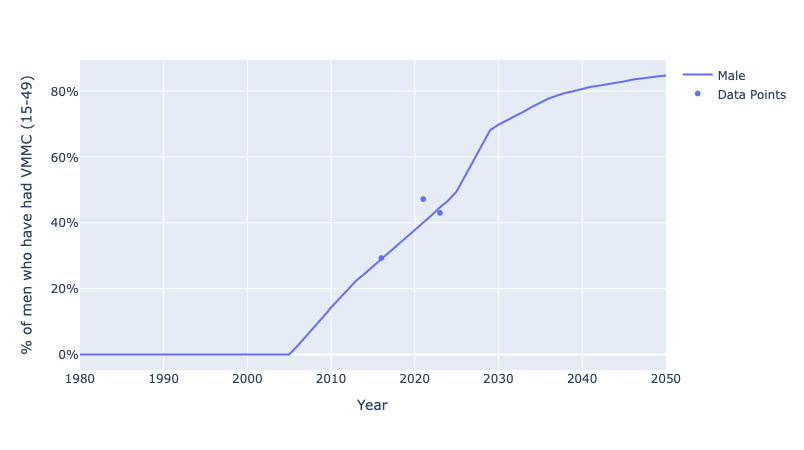

In [353]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_vmmc_prep.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = vmmc_calculator(datalist=datalist, agegroup=[15,50],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VMMC_combined_df_2030 = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
VMMC_combined_df_2030['Year'] = VMMC_combined_df_2030['timepoint'].map(timepoint_to_year)
VMMC_df_2030 = VMMC_combined_df_2030.groupby(['Gender','Year']).agg(
            popsize=('popsize', 'mean'),  # sum acros all models each gender
            sum_circumcised = ('sum_circumcised', 'mean'),
            popsize_all=('popsize', 'sum'),  # sum acros all models each gender
            sum_circumcised_all = ('sum_circumcised', 'sum'),
            vmmcprevalence = ('vmmcprevalence','mean')
        ).reset_index()

VMMC_df_2030['vmmcprevalence_']  = round(VMMC_df_2030['sum_circumcised_all']/VMMC_df_2030['popsize_all'],4)

VMMC_df_2030['vmmcprevalence'] = round(VMMC_df_2030['vmmcprevalence'],4)
VMMC_wide_df_2030 = VMMC_df_2030.pivot(index='Year', columns='Gender', values='vmmcprevalence').reset_index()
VMMC_wide_df_2030.columns.name = None  # Remove the name of the columns index
fig = px.line(data_frame=VMMC_wide_df_2030, x='Year', y=['Male'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", 
    yaxis_title="% of men who have had VMMC (15-49)",
    legend_title=dict(text=""),
    yaxis_tickformat='.0%'
)

# Data points to add
points = [
    {'Year': 2016, 'Men': 0.293,},
    {'Year': 2021, 'Men': 0.472,},
    {'Year': 2023, 'Men': 0.43,}
    # Add more points as needed
]

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='#636EFA', size=6)
    )
)

#### HIV incidence as new infections per 1000

In [354]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_vmmc_prep.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df['Year'] = inc_combined_df['timepoint'].map(timepoint_to_year)
inc_combined_df['Gender'] = inc_combined_df['Gender'].map(gender)

In [355]:
incidence_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_exposure_time=('sum_exposure_time', 'sum'),  
            sum_incident_cases = ('sum_incident_cases', 'sum')
        ).reset_index()

incidence_df['incidence']  = incidence_df['sum_incident_cases']/incidence_df['sum_exposure_time']
incidence_df['incidence'] = round(incidence_df['incidence'] * 1000, 3)

In [356]:
incidence_wide_df = incidence_df.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_wide_df.columns.name = None  # Remove the name of the columns index

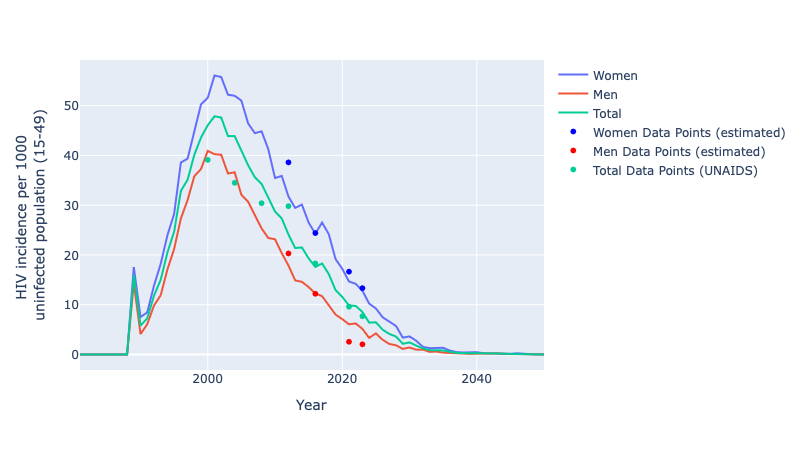

In [357]:
fig = px.line(data_frame=incidence_wide_df, x='Year', y=['Women','Men','Total'],width=980, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 <br>uninfected population  (15-49)",
    legend_title=dict(text="")
)

# Data points to add
points = [
    {'Year': 2000, 'Women': np.nan, 'Men': np.nan,'Total': 39.1},
    {'Year': 2004, 'Women': np.nan, 'Men': np.nan, 'Total': 34.5},
    {'Year': 2008, 'Women': np.nan, 'Men': np.nan, 'Total': 30.4},
    {'Year': 2012, 'Women': 38.6, 'Men': 20.3, 'Total': 29.8}, #shims1 16.5:31.4
    {'Year': 2016, 'Women': 24.4, 'Men': 12.2, 'Total': 18.3}, #shims2 9.9:19.9
    {'Year': 2021, 'Women': 16.64, 'Men': 2.56,'Total': 9.6}, #shims3 2:14.5 Total 7.7
    {'Year': 2023, 'Women': 13.33, 'Men': 2.05, 'Total': 7.69}, #UNAIDS
    # Add more points as needed
]

# Add points for Women
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Women'] for point in points],
        mode='markers',
        name='Women Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Men
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Men'] for point in points],
        mode='markers',
        name='Men Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='#00CC96', size=6)
    )
)

# Show the plot
fig.show()

In [360]:
# Female
100* (6.447  - 3.64)/6.447 

43.53963083604777

In [359]:
#male
100* (2.964 - 1.426 )/2.964 

51.889338731444

In [358]:
# total
100* (4.548 - 2.437)/4.548 

46.41600703605981

In [361]:
# Cost
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data_2030_vmmc_prep.items():
    result_df = person_years_on_prep(datalist=datalist, agegroup=[15,300], timewindow=[45,51])*scaling_factor

    # Append the resulting dataframe to the list
    dfs.append(result_df)
# mean
person_years_on_prep_scale_up = np.mean(dfs)
person_years_on_prep_scale_up

143312.3976057583

In [362]:
143312.40 - 49427.74

93884.66

In [363]:
20*93884.66

1877693.2000000002

In [364]:
## for vmmc cost
import math
math.ceil(VMMC_df.query('Year == 2030')['sum_circumcised'].iloc[0] * scaling_factor)

223895

In [365]:
math.ceil(VMMC_df_2030.query('Year == 2030')['sum_circumcised'].iloc[0] * scaling_factor)

258533

In [366]:
258533 - 223895

34638

In [367]:
34638*50

1731900

In [368]:
1.73+18.78

20.51

In [373]:
100* (6.447-3.64)/6.447

43.53963083604777

In [381]:
100* (2.964-2.206)/2.964

25.573549257759783

In [379]:
100* (4.548-2.437)/4.548

46.41600703605981